In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('equipment_tuning_dataset.csv')
print(df.head())
df.info(); df.describe(include='all')

          F1         F2        F3         F4        F5          F6   F7 F8  \
0  54.967142  38.432217  0.570613  30.050647 -0.339008   91.454516  S07  C   
1  48.617357  48.186940  0.968185  30.815948 -0.362731   94.632581  S06  A   
2  56.476885  13.501745 -0.331308  40.150344 -1.436515  139.568226  S05  C   
3  65.230299  39.186232 -0.612237  36.897056 -0.264072  104.528101  S08  C   
4  47.658466  57.538313 -1.085151  25.133828  0.586263   94.205163  S05  A   

         F9 F10  F11       F12 Needs_Tuning  
0  0.302294  Z2    0  5.118287          Yes  
1  0.948185  Z1    0  4.204698           No  
2  0.595286  Z2    1  6.437193          Yes  
3  0.469348  Z3    1  4.680284           No  
4  0.783041  Z2    1  3.820761           No  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   F1            1250 non-null   float64
 1   F2            

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,Needs_Tuning
count,1250.000000,1250.000000,1154.000000,1250.000000,1250.000000,1250.000000,1250,1250,1166.000000,1250,1250.000000,1250.000000,1250
unique,NaN,NaN,NaN,NaN,NaN,NaN,10,3,NaN,4,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,S08,B,NaN,Z2,NaN,NaN,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,135,433,NaN,351,NaN,NaN,699
mean,50.377088,40.008520,0.001929,29.939434,-0.007571,99.639747,NaN,NaN,0.496415,NaN,0.393600,4.932048,NaN
std,9.888929,29.779004,1.032088,7.931443,1.299155,15.641065,NaN,NaN,0.189756,NaN,0.488743,2.009101,NaN
min,17.587327,8.509809,-2.991136,2.810627,-8.982136,51.684755,NaN,NaN,0.000000,NaN,0.000000,-2.514871,NaN
25%,43.623482,25.130379,-0.712209,24.761290,-0.577992,88.936602,NaN,NaN,0.367878,NaN,0.000000,3.605815,NaN
50%,50.446917,33.708265,0.000185,29.827150,-0.032091,99.380286,NaN,NaN,0.496255,NaN,0.000000,4.967375,NaN
75%,56.612341,46.125163,0.678943,35.274016,0.524421,110.526491,NaN,NaN,0.625014,NaN,1.000000,6.339384,NaN


# 1. Exploratory Data Analysis (EDA)
Identify missing values and outliers, visualize distributions, and analyze class balance.

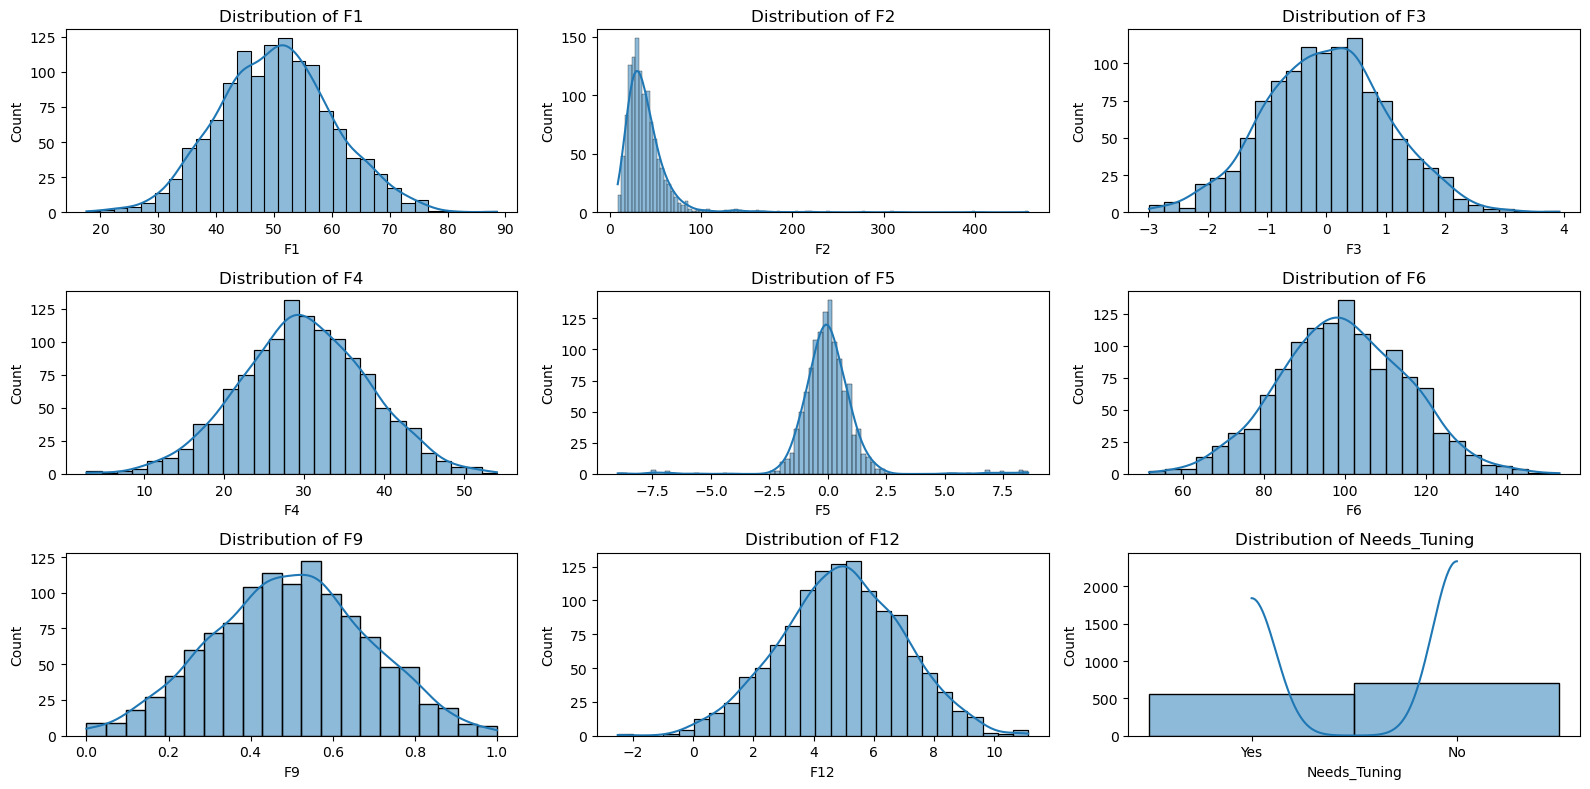

In [78]:
# Visualize distributions
df_numeric = df[["F1", "F2", "F3", "F4", "F5", "F6", "F9", "F12", "Needs_Tuning"]]

fig, axes = plt.subplots(3, 3, figsize=(16, 8))
axes = axes.flatten()

for i, feature in enumerate(df_numeric.columns):
    sns.histplot(df_numeric[feature], ax=axes[i], kde=True)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)

plt.tight_layout()
plt.show()


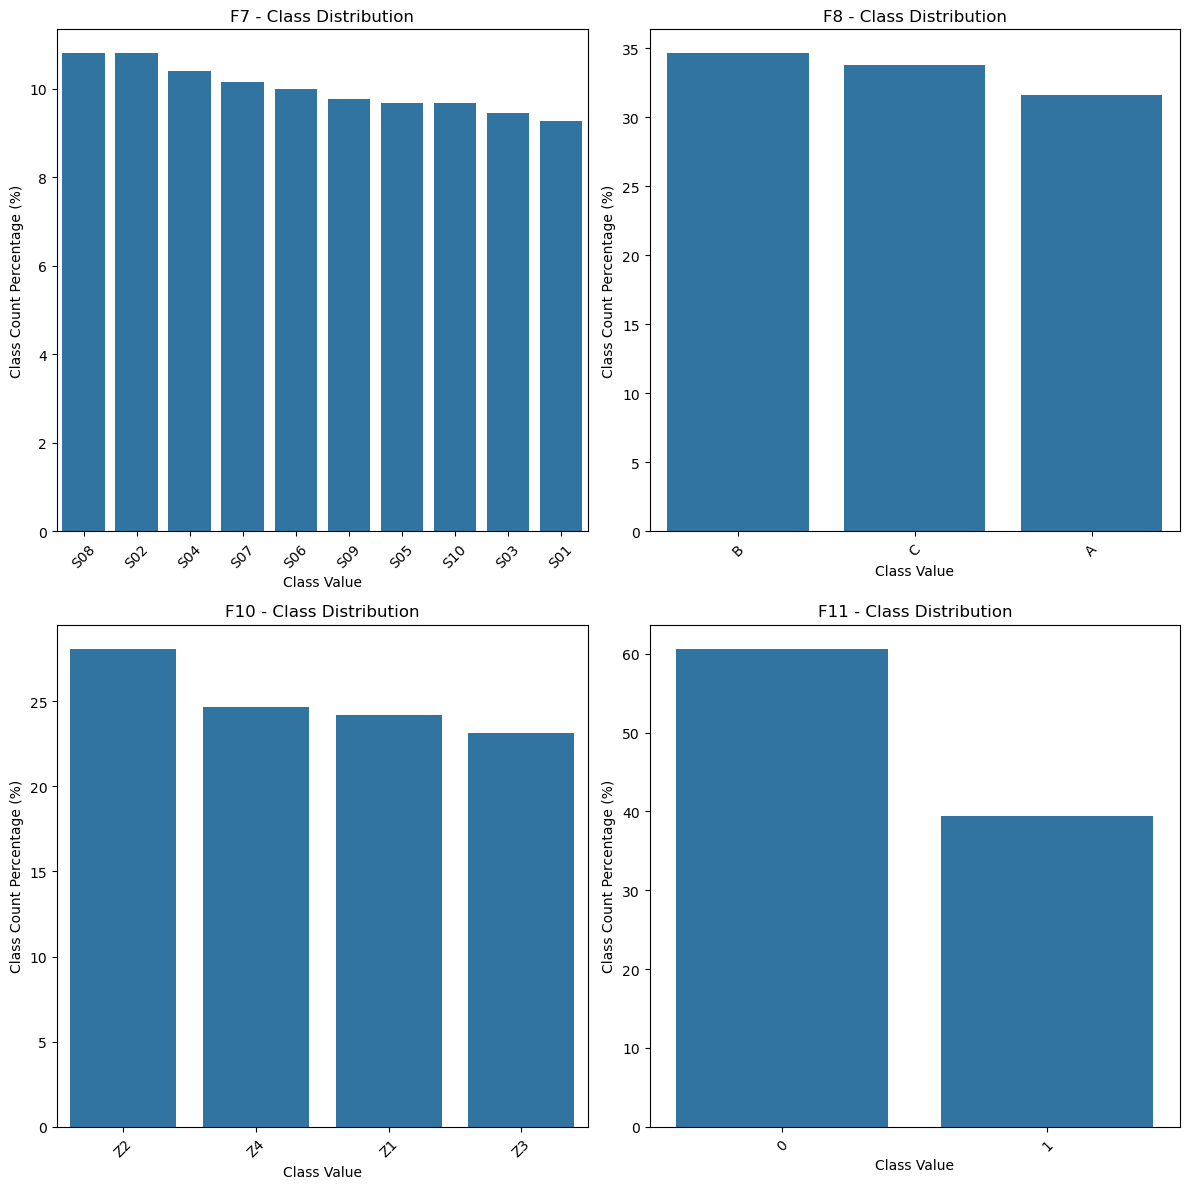

In [79]:
# analyze class balance
df_cat = df[["F7", "F8", "F10", "F11"]]

# Plot category distribution
fig_2, axes_2 = plt.subplots(2, 2, figsize=(12, 12))
axes_2 = axes_2.flatten()
for idx, feature in enumerate(df_cat.columns):
    class_count_percent = df_cat[feature].value_counts() / len(df_cat) * 100
    
    sns.barplot(x=class_count_percent.index, y=class_count_percent.values, ax=axes_2[idx])
    axes_2[idx].set_title(f'{feature} - Class Distribution')
    axes_2[idx].set_xlabel('Class Value')
    axes_2[idx].set_ylabel('Class Count Percentage (%)')
    axes_2[idx].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()



F1              0.0000
F2              0.0000
F3              0.0768
F4              0.0000
F5              0.0000
F6              0.0000
F7              0.0000
F8              0.0000
F9              0.0672
F10             0.0000
F11             0.0000
F12             0.0000
Needs_Tuning    0.0000
dtype: float64
F1: 10 outliers (IQR fences 24.14..76.10)
F2: 57 outliers (IQR fences -6.36..77.62)
F3: 9 outliers (IQR fences -2.80..2.77)
F4: 10 outliers (IQR fences 8.99..51.04)
F5: 32 outliers (IQR fences -2.23..2.18)
F6: 7 outliers (IQR fences 56.55..142.91)
F9: 0 outliers (IQR fences -0.02..1.01)
F12: 6 outliers (IQR fences -0.49..10.44)


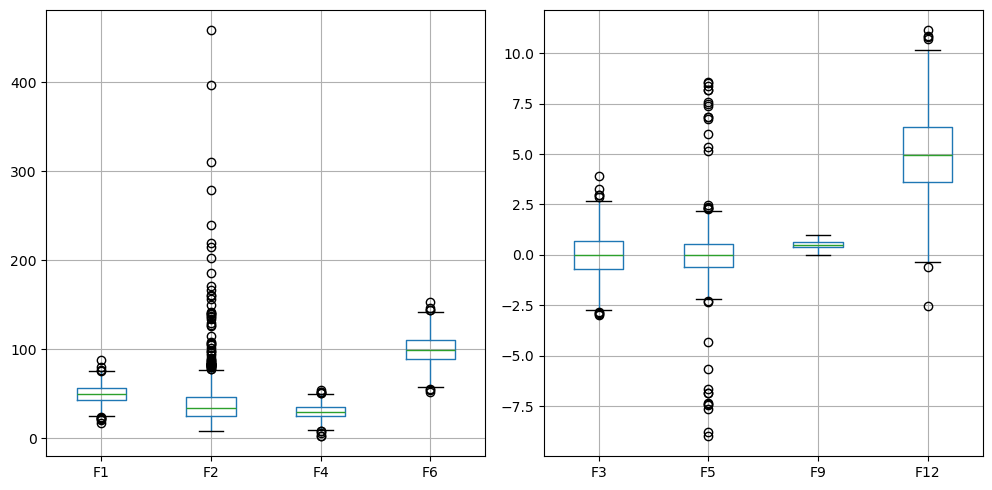

In [80]:
# Identify missing values and outliers
print(df.isna().mean()) # fraction missing per column

# Outliers
def iqr_mask(s, k=1.5):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    return (s < lower) | (s > upper), (lower, upper)

for c in ["F1", "F2", "F3", "F4", "F5", "F6", "F9", "F12"]:
    mask, (lo, hi) = iqr_mask(df[c])
    print(f'{c}: {mask.sum()} outliers (IQR fences {lo:.2f}..{hi:.2f})')

plt.figure(figsize=(15, 5))

plt.subplot(1,3,1)
df[[ 'F1', 'F2', 'F4', 'F6']].boxplot()

plt.subplot(1,3,2)
df[[ 'F3', 'F5', 'F9', 'F12']].boxplot()

plt.tight_layout()
plt.show()

# Data Preprocessing: Handle missing data, encode categorical variables, normalize or scale features, and justify preprocessing steps.

In [81]:
# Handle missing values
# F3 and F9 having missing values which are MCAR, making KNN a suitable choice for imputation
from sklearn.impute import KNNImputer

print(df.isna().mean())

df_filled = df
imputer = KNNImputer(n_neighbors=5)

cols_to_fill = ['F3', 'F9']
df_filled[cols_to_fill] = imputer.fit_transform(df_filled[cols_to_fill])

print(df_filled.isna().mean())

F1              0.0000
F2              0.0000
F3              0.0768
F4              0.0000
F5              0.0000
F6              0.0000
F7              0.0000
F8              0.0000
F9              0.0672
F10             0.0000
F11             0.0000
F12             0.0000
Needs_Tuning    0.0000
dtype: float64
F1              0.0
F2              0.0
F3              0.0
F4              0.0
F5              0.0
F6              0.0
F7              0.0
F8              0.0
F9              0.0
F10             0.0
F11             0.0
F12             0.0
Needs_Tuning    0.0
dtype: float64


In [82]:
# Remove Outliers
df_outliers_present = df_filled.copy()
df_outliers_winsored = df_filled.copy()
df_outliers_removed = df_filled.copy()

# Winsorize outliers
for c in ["F1", "F2", "F3", "F4", "F5", "F6", "F9", "F12"]:
    mask, (lo, hi) = iqr_mask(df_outliers_winsored[c])
    print(f'{c}: {mask.sum()} outliers (IQR fences {lo:.2f}..{hi:.2f})')
    # Winsorize: clip to inner fences
    df_outliers_winsored[c] = df_outliers_winsored[c].clip(lo, hi)

print("\n")

# Trim outliers
combined_mask = pd.Series(False, index=df_outliers_removed.index)

for c in ["F1", "F2", "F3", "F4", "F5", "F6", "F9", "F12"]:
    mask, (lo, hi) = iqr_mask(df_outliers_removed[c])
    print(f'{c}: {mask.sum()} outliers (IQR fences {lo:.2f}..{hi:.2f})')
    combined_mask = combined_mask | mask

# remove rows with outliers
df_outliers_removed = df_outliers_removed[~combined_mask].reset_index(drop=True)


F1: 10 outliers (IQR fences 24.14..76.10)
F2: 57 outliers (IQR fences -6.36..77.62)
F3: 18 outliers (IQR fences -2.51..2.48)
F4: 10 outliers (IQR fences 8.99..51.04)
F5: 32 outliers (IQR fences -2.23..2.18)
F6: 7 outliers (IQR fences 56.55..142.91)
F9: 12 outliers (IQR fences 0.02..0.98)
F12: 6 outliers (IQR fences -0.49..10.44)


F1: 10 outliers (IQR fences 24.14..76.10)
F2: 57 outliers (IQR fences -6.36..77.62)
F3: 18 outliers (IQR fences -2.51..2.48)
F4: 10 outliers (IQR fences 8.99..51.04)
F5: 32 outliers (IQR fences -2.23..2.18)
F6: 7 outliers (IQR fences 56.55..142.91)
F9: 12 outliers (IQR fences 0.02..0.98)
F12: 6 outliers (IQR fences -0.49..10.44)


In [91]:
# Normalize or scale features
from sklearn.preprocessing import StandardScaler

df_outliers_present_numeric = df_outliers_present[["F1", "F2", "F3", "F4", "F5", "F6", "F9", "F12"]]
df_outliers_winsored_numeric = df_outliers_winsored[["F1", "F2", "F3", "F4", "F5", "F6", "F9", "F12"]]
df_outliers_removed_numeric = df_outliers_removed[["F1", "F2", "F3", "F4", "F5", "F6", "F9", "F12"]]

std_scaler = StandardScaler()

# scale df with outliers present
df_scaled_outliers_present = std_scaler.fit_transform(df_outliers_present_numeric.to_numpy())
df_scaled_outliers_present = pd.DataFrame(df_scaled_outliers_present, columns=[
  "F1", "F2", "F3", "F4", "F5", "F6", "F9", "F12"])

# scale df with outliers winsorized
df_scaled_outliers_winsored = std_scaler.fit_transform(df_outliers_winsored_numeric.to_numpy())
df_scaled_outliers_winsored = pd.DataFrame(df_scaled_outliers_winsored, columns=[
  "F1", "F2", "F3", "F4", "F5", "F6", "F9", "F12"])

#scale df with outliers removed
df_scaled_outliers_removed = std_scaler.fit_transform(df_outliers_removed_numeric.to_numpy())
df_scaled_outliers_removed = pd.DataFrame(df_scaled_outliers_removed, columns=[
  "F1", "F2", "F3", "F4", "F5", "F6", "F9", "F12"])

print(df_scaled_outliers_present.head())

         F1        F2        F3        F4        F5        F6        F9  \
0  0.464347 -0.052955  0.572199  0.014027 -0.255219 -0.523526 -1.051392   
1 -0.178021  0.274747  0.970581  0.110556 -0.273487 -0.320258  2.456591   
2  0.617078 -0.890473 -0.331561  1.287912 -1.100342  2.553820  0.539914   
3  1.502605 -0.027624 -0.613062  0.877571 -0.197516  0.312658 -0.144085   
4 -0.275026  0.588898 -1.086940 -0.606135  0.457276 -0.347595  1.559654   

        F12  
0  0.092735  
1 -0.362172  
2  0.749463  
3 -0.125362  
4 -0.553347  


In [84]:
# Encode categorical variables

from sklearn.model_selection import train_test_split

df_scaled_outliers_present_cat = df_outliers_present[["F7", "F8", "F10", "F11"]]
df_outliers_winsored_cat = df_outliers_winsored[["F7", "F8", "F10", "F11"]]
df_outliers_removed_cat = df_outliers_removed[["F7", "F8", "F10", "F11"]]

# print(df_outliers_winsored_cat.head(5))
# print(df_scaled_outliers_winsored.head(5))

df_combined_present = pd.concat([df_scaled_outliers_present, df_scaled_outliers_present_cat], axis=1)
df_combined_winsored = pd.concat([df_scaled_outliers_winsored, df_outliers_winsored_cat], axis=1)
df_combined_removed = pd.concat([df_scaled_outliers_removed, df_outliers_removed_cat], axis=1)

# Outliers present
X_1 = df_combined_present
y_1 = df_outliers_present['Needs_Tuning']
X_1 = pd.get_dummies(X_1, drop_first=True)

# Outliers winsored
X_2 = df_combined_winsored
y_2 = df_outliers_winsored['Needs_Tuning']
X_2 = pd.get_dummies(X_2, drop_first=True)

#Outliers removed
X_3 = df_combined_removed
y_3 = df_outliers_removed['Needs_Tuning']
X_3 = pd.get_dummies(X_3, drop_first=True)

# 3. Model Training: Implement and evaluate the following models:
- k-Nearest Neighbors (kNN)
- Na ̈ıve Bayes
- Support Vector Machine (SVM)
- Decision Tree
- Random Forest
- Logistic Regression
- Multi-Layer Perceptron (MLP)

In [85]:
# Models (fit/score pattern)
# Model training WITHOUT test/train split for comparison to later split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR
from sklearn.neural_network import MLPClassifier as MLP

models = { 
    'KNN': Pipeline([('sc', StandardScaler(with_mean=False)), ('mdl', KNN())]),
    'NB' : GaussianNB(),
    'SVM': Pipeline([('sc', StandardScaler(with_mean=False)), ('mdl', SVC())]),
    'DT' : DT(), 
    'RF' : RF(n_estimators=200, random_state=42),
    'LR' : Pipeline([('sc', StandardScaler(with_mean=False)), ('mdl', LR(max_iter=1000))]),
    'MLP': Pipeline([('sc', StandardScaler(with_mean=False)), ('mdl', MLP(max_iter=2000, random_state=42))]) 
}

results_1_no_split = {}
results_2_no_split = {}
results_3_no_split = {}

for name, model in models.items():
    model.fit(X_1, y_1)

    y_pred_1 = model.predict(X_1)

    acc_1 = accuracy_score(y_1, y_pred_1)

    results_1_no_split[name] = round(acc_1, 4)  

for name, model in models.items():
    model.fit(X_2, y_2)

    y_pred_2 = model.predict(X_2)

    acc_2 = accuracy_score(y_2, y_pred_2)

    results_2_no_split[name] = round(acc_2, 4) 

for name, model in models.items():
    model.fit(X_3, y_3)

    y_pred_3 = model.predict(X_3)

    acc_3 = accuracy_score(y_3, y_pred_3)

    results_3_no_split[name] = round(acc_3, 4)

print("======No Test Train Split======")
print(f"Outliers Present: {results_1_no_split}")
print(f"Outliers Winsorised: {results_2_no_split}")
print(f"Outliers Removed: {results_3_no_split}")

======No Test Train Split======
Outliers Present: {'KNN': 0.7008, 'NB': 0.6464, 'SVM': 0.7544, 'DT': 1.0, 'RF': 1.0, 'LR': 0.632, 'MLP': 1.0}
Outliers Winsorised: {'KNN': 0.7112, 'NB': 0.6528, 'SVM': 0.7656, 'DT': 1.0, 'RF': 1.0, 'LR': 0.6304, 'MLP': 1.0}
Outliers Removed: {'KNN': 0.7072, 'NB': 0.6459, 'SVM': 0.7568, 'DT': 1.0, 'RF': 1.0, 'LR': 0.6297, 'MLP': 1.0}


# 4. Validation: Use both train/test split and 5-fold cross-validation to compare accuracy.

======Used Test Train Split======
Outliers Present: {'KNN': 0.548, 'NB': 0.644, 'SVM': 0.62, 'DT': 0.588, 'RF': 0.664, 'LR': 0.624, 'MLP': 0.588}
Outliers Winsorised: {'KNN': 0.572, 'NB': 0.624, 'SVM': 0.636, 'DT': 0.572, 'RF': 0.636, 'LR': 0.624, 'MLP': 0.576}
Outliers Removed: {'KNN': 0.5631, 'NB': 0.5586, 'SVM': 0.6216, 'DT': 0.5405, 'RF': 0.6216, 'LR': 0.6036, 'MLP': 0.5495}


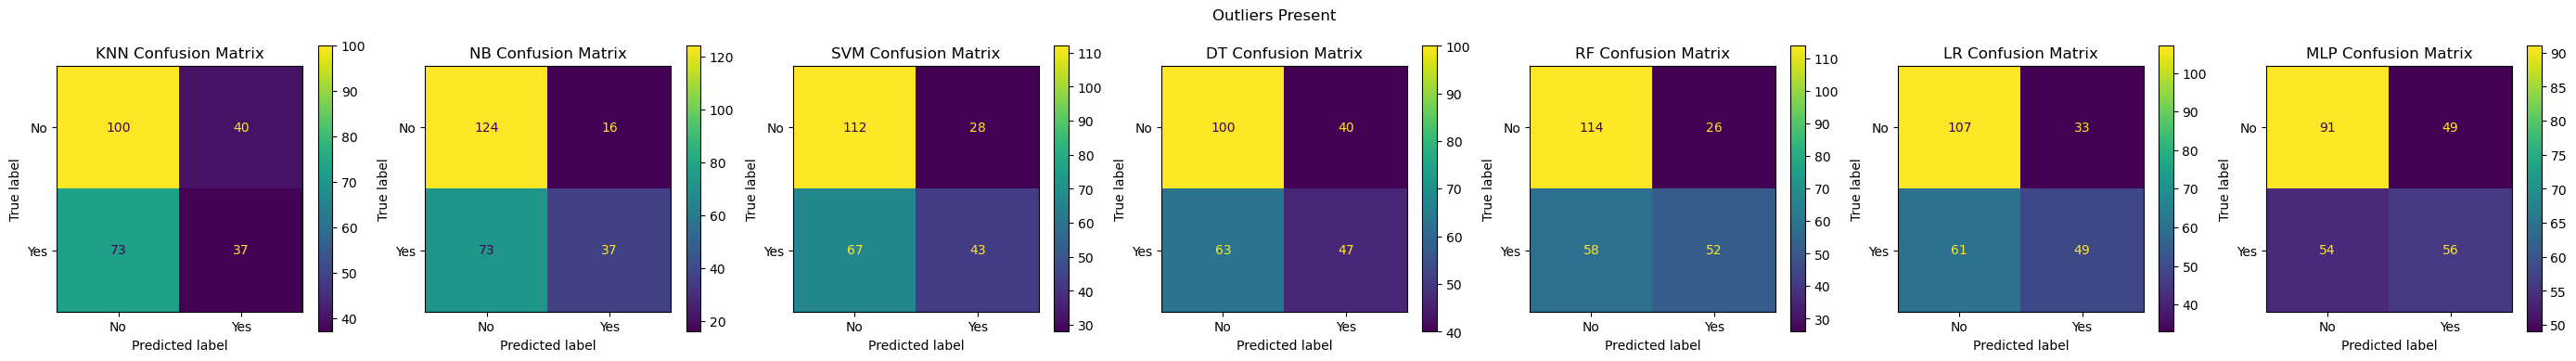

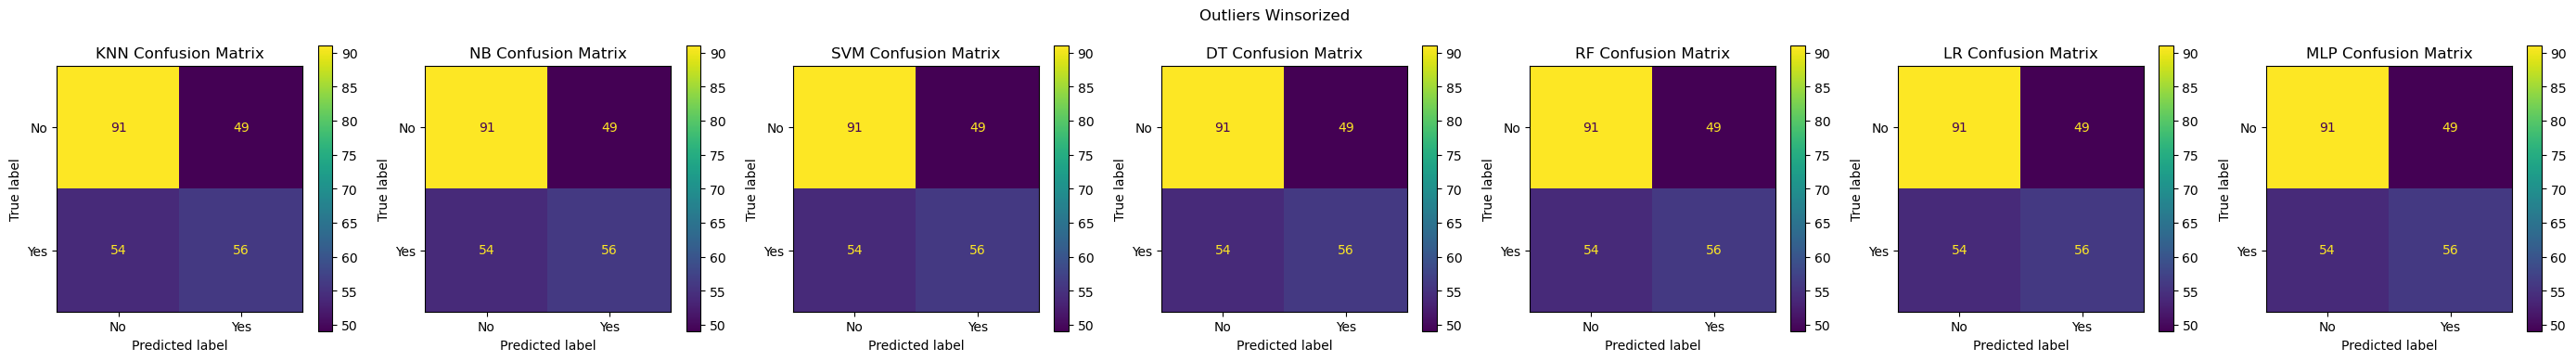

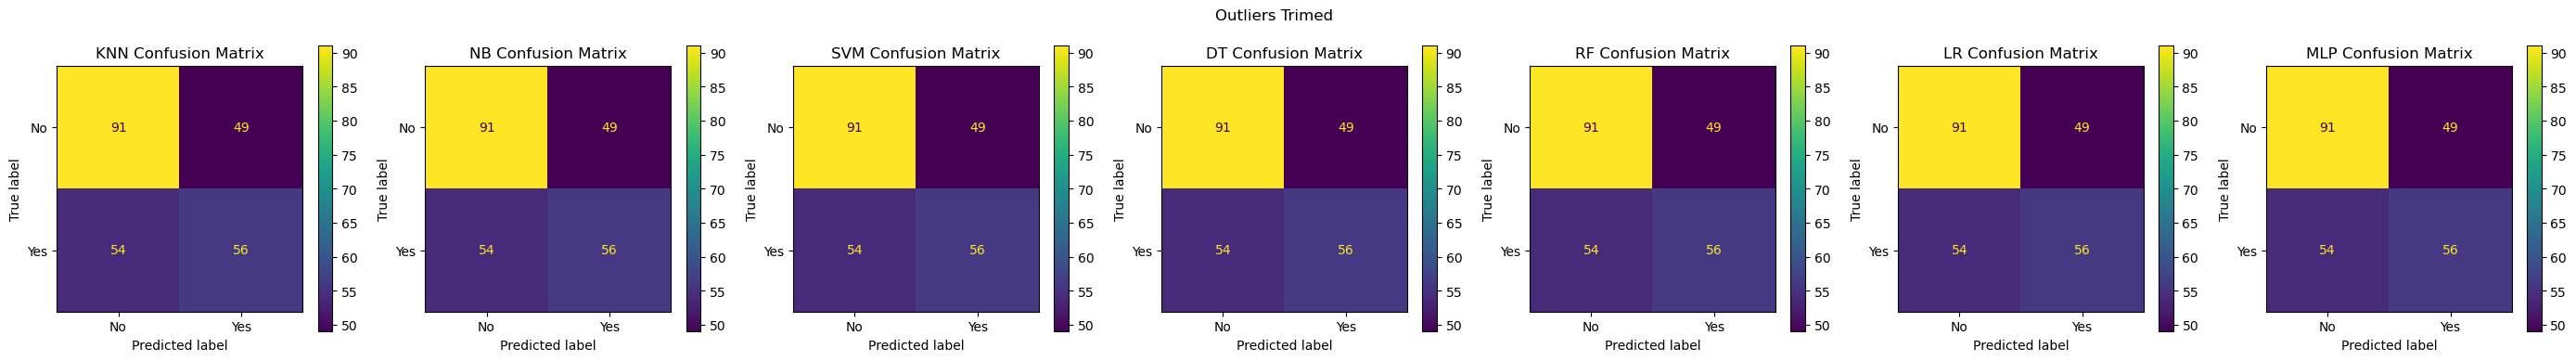

In [90]:
# Re-train with test/train split present for comparison
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, stratify=y_1,
random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, stratify=y_2,
random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, stratify=y_3,
random_state=42)

results_1_split = {}
results_2_split = {}
results_3_split = {}


fig_1, axes_1 = plt.subplots(1, 7, figsize=(35, 4))
axes_1 = axes_1.flatten()

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train_1, y_train_1)

    y_pred_1 = model.predict(X_test_1)

    acc_1 = accuracy_score(y_test_1, y_pred_1)

    results_1_split[name] = round(acc_1, 4)  

    disp_1 = ConfusionMatrixDisplay(confusion_matrix(y_test_1, y_pred_1),
                                   display_labels=model.classes_)
    # Plot on the correct subplot
    disp_1.plot(ax=axes_1[i])
    axes_1[i].set_title(f"{name} Confusion Matrix")
plt.suptitle("Outliers Present")

fig_2, axes_2 = plt.subplots(1, 7, figsize=(35, 4))
axes_2 = axes_2.flatten()

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train_2, y_train_2)

    y_pred_2 = model.predict(X_test_2)

    acc_2 = accuracy_score(y_test_2, y_pred_2)

    results_2_split[name] = round(acc_2, 4) 

    disp_2 = ConfusionMatrixDisplay(confusion_matrix(y_test_2, y_pred_2),
                                   display_labels=model.classes_)
    # Plot on the correct subplot
    disp.plot(ax=axes_2[i])
    axes_2[i].set_title(f"{name} Confusion Matrix")
plt.suptitle("Outliers Winsorized")

fig_3, axes_3 = plt.subplots(1, 7, figsize=(35, 4))
axes_3 = axes_3.flatten()

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train_3, y_train_3)

    y_pred_3 = model.predict(X_test_3)

    acc_3 = accuracy_score(y_test_3, y_pred_3)

    results_3_split[name] = round(acc_3, 4)

    disp_3 = ConfusionMatrixDisplay(confusion_matrix(y_test_3, y_pred_3),
                                   display_labels=model.classes_)
    # Plot on the correct subplot
    disp.plot(ax=axes_3[i])
    axes_3[i].set_title(f"{name} Confusion Matrix")
plt.suptitle("Outliers Trimed")

print("======Used Test Train Split======")
print(f"Outliers Present: {results_1_split}")
print(f"Outliers Winsorised: {results_2_split}")
print(f"Outliers Removed: {results_3_split}")


In [87]:
# Cross Validation & Box Plot
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

scores_1 = {name: cross_val_score(mdl, X_1, y_1, cv=5, scoring='accuracy') for name, mdl in
models.items()}
scores_2 = {name: cross_val_score(mdl, X_2, y_2, cv=5, scoring='accuracy') for name, mdl in
models.items()}
scores_3 = {name: cross_val_score(mdl, X_3, y_3, cv=5, scoring='accuracy') for name, mdl in
models.items()}


# 5. Visualization: Create a box plot of accuracies for all models.

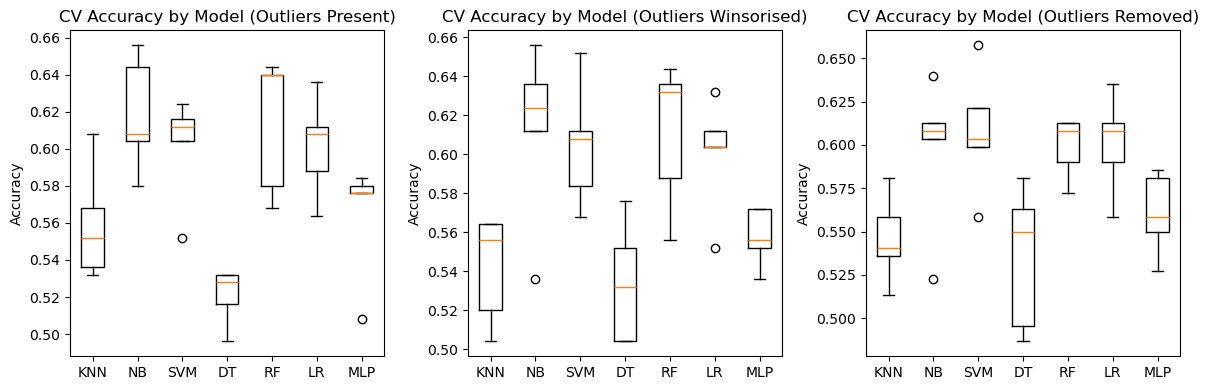

In [88]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.boxplot(scores_1.values(), tick_labels=scores_1.keys())
plt.ylabel('Accuracy')
plt.title('CV Accuracy by Model (Outliers Present)')

plt.subplot(1, 3, 2)
plt.boxplot(scores_2.values(), tick_labels=scores_2.keys())
plt.ylabel('Accuracy')
plt.title('CV Accuracy by Model (Outliers Winsorised)')

plt.subplot(1, 3, 3)
plt.boxplot(scores_3.values(), tick_labels=scores_3.keys())
plt.ylabel('Accuracy')
plt.title('CV Accuracy by Model (Outliers Removed)')

plt.tight_layout()
plt.show()

# 6. Discussion: Analyze which preprocessing and model choices led to higher accuracy, and discuss trade-offs in interpretability and complexity.

- Pre-processing made a significant impact in two areas: outlier-handling and the test-train split
- Models were trained with and without a test-train split; from the accuracy metrics of each of these models
    - The models without a test-train split saw a much higher degree of accuracy,
      this is likely due to overfitting from the lack of test-train split,
      rather than a reflection of the actual accuracy of the model, as without the split,
    - Random Forest and Decision Tree both achieve an accuracy of 1.0, or perfect accuracy, which is practically impossible
- 3 forms of outlier-handling were implemented: no handling (outliers present), winsorisation, and trimming
  these 3 methods were applied to both datasets with a test-train split and those without
- Un-split dataset:
    - accuracy was fairly similar across all three methods,
    - trimming had a slightly higher KNN and MLP accuracy
    - winsorisation had slightly higher accuracy in all other models
    - this indicates some form of outlier handling improves accuracy over no handling
- Split dataset:
    - accuracy remained fairly similar acorss all 3 methids
    - winsorisation showed the highest accuracy for KNN, SVM, DT, RF and LR
    - no-handling had the highest accuracy for naive bayes
    - trimming had the highest accuracy for logistic regression and MLP
    - from these findings, it can be concluded that outliers are important to this problem and it is best not to use imputation in order to
      maximize accuracy in this case, regardless of the test-train split
    
- The trade-off between accuracy and interpretability & complexity is a frequently
  discussed issue in ML, although it dosen't appear to be highly relevant to the case at hand
- Comparing the highest accuracy scores between inherently interpretable models (KNN, NB, DT, LR) and
  non-inherently interpretable models (SVM, RF, MLP)
  within the datasets which used a train-test split, there appears to be an even
  disitribution of highest accuracy scores between interpretable and non-interpretable models
    - the highest accuracy for non-handling is NB
    - the highest accuracy for winsorising is RF
    - the highest accuracy for trimming is logistic regression
    - Overall highest accuracy was in the no-outlier dataset,
      with RF having the highest accuracy at 0.664 and NB having the second highest at 0.644
    - The mix of interpretablility between NB, RF and LR shows that the trade-off isn't majorly significant in this case
- Also, there was a low variance of accuracy scores across models, which indicates that there is very little trade off in accuracy
  to interpretability when comparing between inherently interpretable vs. non-inherenrtly interpretable models

- Ultimatley there will always be some degree of trade-off between interpretability and complexity, as generally,
  as a concept in any domain becomes more complex, it becomes more difficult to understand.
- On the contrary, non-inherently interpretable models like SVM or MLP can be made interpretable
  with the assistance of tools like LIME or SHAP, which provide explanations of these models decisions, helping to mitigate the trade-off.